<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим данные и посмотрим на них

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scs
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error,mean_squared_error
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv',parse_dates = ['datetime'],index_col =[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим на пропущенные значения

In [5]:
for col in df.columns:
    print(f'Пропущенных значений в столбце {col}: {(len(df) - df[col].count())/len(df):.1%}')  

Пропущенных значений в столбце num_orders: 0.0%


Сделаем ресемпл ряда по 1 часу и посмотрим на график

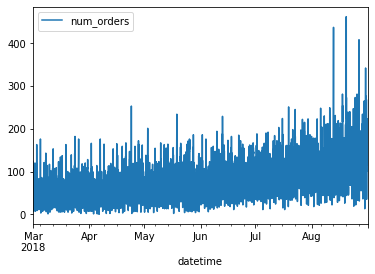

In [6]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.plot()
df1 = df.copy()

## Анализ

С помощью критерия Дики-Фуллера проверим временной ряд на стационарность.

In [7]:
result = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
Нулевая гипотеза отвергнута – Временной ряд стационарен
	5%: -2.862
Нулевая гипотеза отвергнута – Временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


Ряд стационарен, посмотрим на его тренд, сезонность и остатки

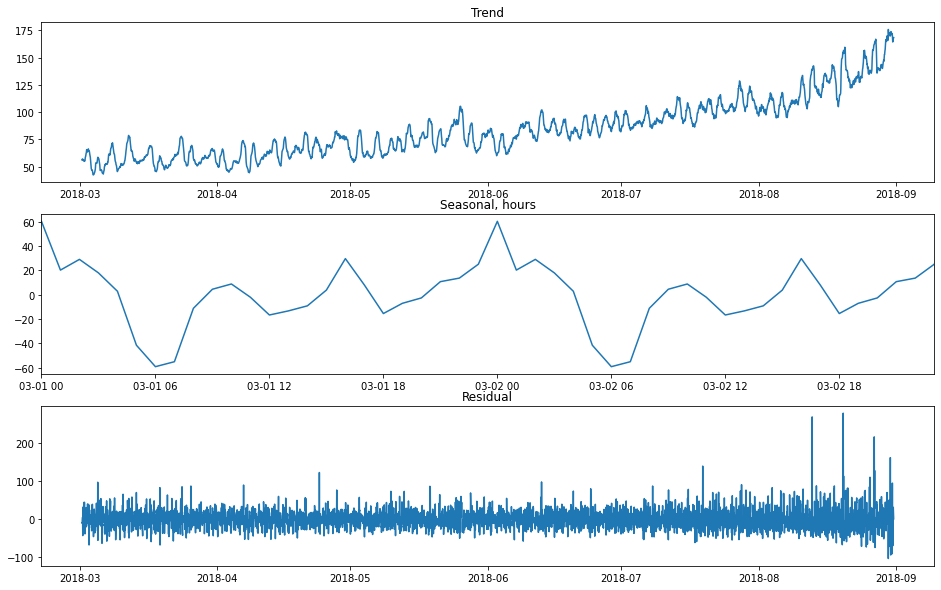

In [8]:
decomposed = seasonal_decompose(df1)

fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal)
axs[1].set_title("Seasonal, hours")
axs[1].set_xlim(left = pd.to_datetime('2018-03-01 00:00:00'),right=pd.to_datetime('2018-03-02 23:00:00'))

axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

Как видно внутри дня есть некая сезонность, днём количество заказов повышается и достигает пика в 12 ночи, далее снижается до 6 утра.

Теперь, хоть и критерий Дики-Фуллера говорит что ряд стационарен, мы заметили на графике что некоторая сезонность присутствует. Уберём её сначала с помощью разности временного ряда

In [9]:
df1 = df - df.shift(fill_value=0)

Далее для того чтобы принять решение что делать с рядом попробуем 2 варианта: 

1) Скользящее среднее

2) Логарифмирование

Прологарифмируем ряд для того чтобы он не уходил "в разнос"  

In [10]:
df1['y'] = np.log10(df1['num_orders'])

Как видно, логарифм хорошо стандартизирует ряд

<AxesSubplot:xlabel='datetime'>

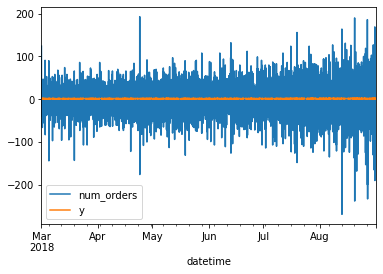

In [13]:
df1.plot()

Теперь используем скользящее среднее

In [14]:
df1['rolling_mean'] = df1['num_orders'].rolling(6).mean()

Судя по графику, скользящее среднее делает это несколько хуже, чем логарифмирование

<AxesSubplot:xlabel='datetime'>

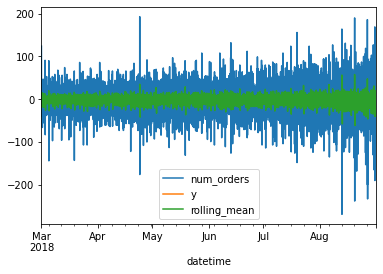

In [15]:
df1.plot()

Проверим на пропущенные значения

In [16]:
for col in df1.columns:
    print(f'Пропущенных значений в столбце {col}: {(len(df1) - df1[col].count())/len(df1):.1%}')  

Пропущенных значений в столбце num_orders: 0.0%
Пропущенных значений в столбце y: 48.0%
Пропущенных значений в столбце rolling_mean: 0.1%


Напишем функцию для стандартизации временного ряда и создания признаков для обучения модели

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [21]:
df_new = make_features(df, 24, 70)

Разделим наши данные на тренировочную и тестовую выборку

In [22]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'],axis = 1)
X_test = test.drop(['num_orders'],axis = 1)
y_train= train['num_orders']
y_test= test['num_orders']

tscv = TimeSeriesSplit(n_splits=5)

In [30]:
def GridSearch(est,params,X_train,y_train):
    grid_search_cv_est = GridSearchCV(est,params,scoring='neg_root_mean_squared_error',cv = tscv)
    grid_search_cv_est.fit(X_train,y_train)
    best_param = grid_search_cv_est.best_params_
    best_est_est = grid_search_cv_est.best_estimator_
    return best_est_est,best_param

## Обучение

Обучим линейную регрессию

In [35]:
model = LinearRegression()

params = {'fit_intercept':['True','False'],
         'normalize':['True','False'],
         'positive':['True','False']}


best_clf1,best_param = GridSearch(model,params,X_train,y_train)
print(best_param)

pred = best_clf1.predict(X_train)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred, squared=False))

{'fit_intercept': 'True', 'normalize': 'True', 'positive': 'True'}
RMSE обучающей выборки: 26.416301583158717


Обучим градиентный бустинг

In [37]:
model = CatBoostRegressor(verbose = False,loss_function = 'RMSE',learning_rate = 0.08)

params = {"iterations": [100,150],
          "depth": [5,8]}


best_clf1,best_param = GridSearch(model,params,X_train,y_train)
print(best_param)

pred = best_clf1.predict(X_train)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred, squared=False))

{'depth': 8, 'iterations': 150}
RMSE обучающей выборки: 17.156480856706587
RMSE тестовой выборки:  40.709421475016185


Вывод: Градиентый бустинг оказался сильно лучше линейной регрессии хоть и немного переобучился. 

## Тестирование

In [25]:
pred_test = model.predict(X_test)
print("RMSE тестовой выборки: ", mean_squared_error(y_test,pred_test, squared = False))

RMSE тестовой выборки:  40.709421475016185


Посмотрим на график исходного и предсказанного трейна. 

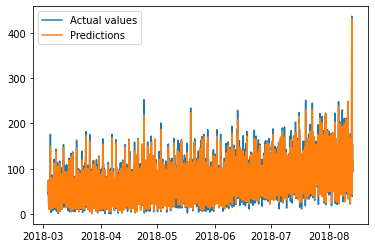

In [26]:
plt.plot(X_train.index, y_train, label='Actual values')
plt.plot(X_train.index, pred, label='Predictions')
plt.legend()
plt.show()

Как видно они практически идентичны. Теперь тест

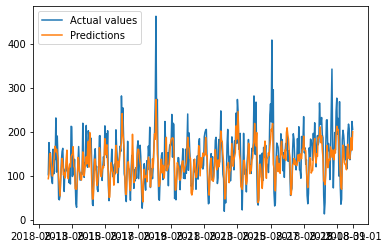

In [27]:
plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, pred_test, label = 'Predictions')
plt.legend()
plt.show()

Здесь модель тоже справилась достаточно хорошо и точно предсказала временной ряд

## Вывод

Градиентный бустинг хорошо показывает себя при предсказании временных рядов